## Speed as Rhythm

### Background

Human and animal locomotion establishes a tight connection between movement in space and rhythm. For example, [Laffi et al., 2024](https://nyaspubs.onlinelibrary.wiley.com/doi/full/10.1111/nyas.15271) quantified the rhythmic differences in the temporal structure of horses' walk, trot, and canter, and promised to better explore the connection between rhythmic regularity and locomotor speed. In human-computer interaction, it has been previously shown how it is possible to control the trajectories of objects in the two-dimensional space by producing rhythmic cells [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), each cell being formed by duplets or triplets of pulses, whose Inter-Onset-Interval (IOI) is inversely proportional to one of the two orthogonal components of velocity. The movement of an object in space can be monitored just by rhythm [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), or by a combination of rhythm, pitch, and spatialization [Bellino et al., 2024](https://dl.acm.org/doi/abs/10.1145/3678299.3678340). 

In data sonification, pitch and rhythm (or IOI) of sounds can be equally effective for auditorilly graphing time-series data [Guiotto et al., 2024](https://iopscience.iop.org/article/10.3847/1538-3881/ad2943/meta), and rhytm perception can also effectively occur in haptics [Bernard et al., 2022](https://www.nature.com/articles/s41598-022-08152-w). 

With audition, there are opportunities and limits of the use of rhythm for the perception and control of trajectories in space. Namely, humans can segregate concurrent auditory streams [Hermes, 2023](https://link.springer.com/content/pdf/10.1007/978-3-031-25566-3.pdf), and detect and reproduce IOIs and their ratios [Nave et al., 2023](https://www.sciencedirect.com/science/article/pii/S0010027723002688?via%3Dihub). 

It has been shown that the production of rhythmic cells by means of two buttons is suitable for controlling trajectories in space [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), but the role of auditory feedback in filling blanks of visual information, as trajectories could be imagined as well as deduced from rhythm. In the proposed experiments, we address the specific question of how accurate the perception and production of speed and direction are. 


### Objectives

1. Showing that humans can interpret two overlapping rhythms and reproduce the direction and speed of a moving object, when each of the two rhythms is made to correspond to one of the components of the velocity vector;
2. Showing that it is possible to produce two overlapping rhythms that correspond to a visually perceived linear motion trajectory;
3. Measuring the accuracy and precision of perception and action of rhythmic trajectories, by two tasks of multisensory translation between perception and action.

In [7]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

sns.set(style="darkgrid")


In [8]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 90), quadrant_column] = 'I'
    df.loc[valid_mask & (angles >= 90) & (angles < 180), quadrant_column] = 'II'
    df.loc[valid_mask & (angles >= 180) & (angles < 270), quadrant_column] = 'III'
    df.loc[valid_mask & (angles >= 270), quadrant_column] = 'IV'


    return df

In [9]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'II')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'III'))

    v_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'II'))

    b_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'II'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.

In [10]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [11]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [12]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip
19,19,37.684478,304.816029,15.552421,335.947471,1740393556366,1740393576186,1740393588649,1394.330718,969.663711,1,IV,IV,N
24,24,28.267477,317.873231,27.334524,319.398705,1740393650899,1740393658815,1740393665898,1430.961216,1582.189494,1,IV,IV,N
25,25,33.835866,126.027625,41.138586,168.690068,1740393670399,1740393680921,1740393685631,1507.430202,1096.322995,1,II,II,N
26,26,72.207546,143.044079,60.287944,142.774601,1740393690131,1740393694073,1740393697281,519.922342,691.065773,1,II,II,N
27,27,30.696642,218.376044,52.092136,230.460213,1740393701782,1740393706405,1740393710114,1246.637830,1574.217141,1,III,III,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,II,II,N
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IV,IV,N
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,I,I,N
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IV,IV,N


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 

In [13]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')
print(errors_df)

df_counts = errors_df.groupby(['flip'])['Count'].sum()/NPart
print("average number of flips per participant = ")
df_counts

    nPart flip  Count
0       1    H      1
1       1    N     38
2       1    V      1
3       2    N     39
4       2    V      1
5       3    N     37
6       3    V      3
7       4    N     40
8       5    B      1
9       5    N     38
10      5    V      1
11      6    N     40
12      7    N     37
13      7    V      3
14      8    N     37
15      8    V      3
16      9    N     39
17      9    V      1
18     10    N     40
19     11    N     38
20     11    V      2
21     12    N     37
22     12    V      3
23     13    H      2
24     13    N     34
25     13    V      4
26     14    N     38
27     14    V      2
28     15    N     38
29     15    V      2
30     16    H      1
31     16    N     38
32     16    V      1
33     17    B      1
34     17    N     38
35     17    V      1
36     18    N     40
37     19    N     39
38     19    V      1
39     20    N     37
40     20    V      3
average number of flips per participant = 


flip
B     0.1
H     0.2
N    38.1
V     1.6
Name: Count, dtype: float64

In [14]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 38


In [15]:
dfN.tail()

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip
14,14,94.444180,77.813256,76.405201,84.699073,1741191813808,1741191817440,1741191819990,1504.736993,324.971254,20,I,I,N
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,II,II,N
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IV,IV,N
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,I,I,N
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IV,IV,N


### Histograms of generated speed and angle. 
Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes. 

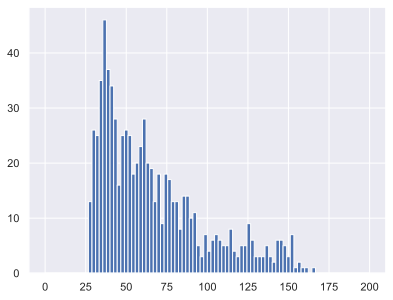

In [16]:
plt.hist(dfN.soundSpeed, bins=90, range = (0, 200));

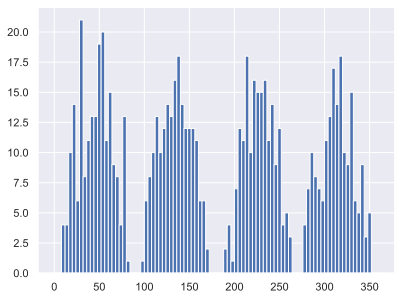

In [17]:
plt.hist(dfN.soundAngle,bins=90, range=(0,360));

### Statistics of angle and speed error
TBD: 
- Normality test
- skewness and kurtosis
- significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [18]:
errAngle = dfN.movAngle - dfN.soundAngle
print(np.mean(errAngle))
print(np.std(errAngle))

-0.12010458436610644
13.003019172861446


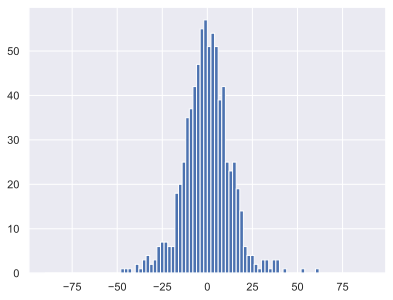

In [19]:
plt.hist(errAngle, bins=90, range = (-90,90));

In [20]:
errSpeed = dfN.soundSpeed - dfN.movSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))

-12.955674264514284
39.36857503629376


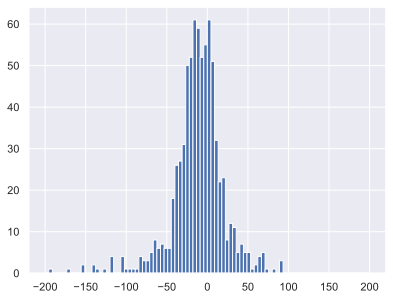

In [21]:
plt.hist(errSpeed, bins=90, range=(-200, 200));

Do participant think longer when they have smaller errors? Apparently not.

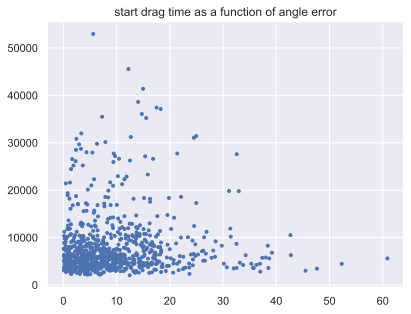

In [22]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN.startDragTime-dfN.soundStart), '.')
ax.set_title('start drag time as a function of angle error');

# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [35]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [36]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [37]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
38,38,29.069538,139.792341,18.510638,148.937093,1740394576071,1740394590426,1740394584867,1740394592318,1740394588008,1351.309406,1598.625247,1,II,II,N
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,II,II,N
14,14,31.558088,134.454512,36.150549,133.707467,1740394315892,1740394322676,1740394319730,1740394323877,1740394320878,1357.375186,1331.772242,1,II,II,N
13,13,77.480473,342.555969,67.151947,340.139432,1740394306524,1740394308565,1740394310764,1740394309040,1740394312079,405.859724,1291.620691,1,IV,IV,N
12,12,32.529874,42.008159,26.163425,44.258234,1740394295225,1740394301120,1740394298062,1740394302721,1740394299705,1241.140979,1378.032018,1,I,I,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,I,I,N
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,II,II,N
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IV,IV,N
9,9,92.749237,200.641512,36.119262,148.705422,1741191122743,1741191133175,1741191130539,1741191134147,1741191132138,345.641464,917.545167,20,III,II,V


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 

In [38]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')
errors_df

df_counts = errors_df.groupby(['flip'])['Count'].sum()/NPart
print("average number of flips per participant = ")
df_counts

average number of flips per participant = 


flip
H     0.1
N    39.5
V     0.4
Name: Count, dtype: float64

In [39]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 10


In [40]:
dfN.tail()

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
13,13,64.367225,207.666240,34.939732,214.189027,1741191175307,1741191181820,1741191178495,1741191182858,1741191180023,526.242386,1003.780659,20,III,III,N
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,I,I,N
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,II,II,N
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IV,IV,N
39,39,56.230280,236.645440,43.161428,231.189298,1741191483474,1741191494304,1741191489578,1741191495413,1741191490470,970.357306,638.729173,20,III,III,N


### Histograms of generated speed and angle.

Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes.


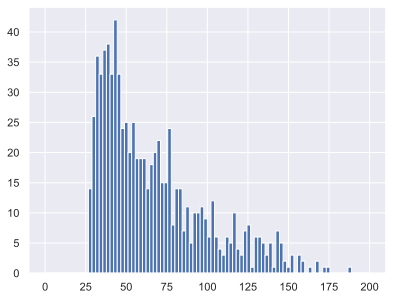

In [41]:
plt.hist(df.movSpeed, bins=90, range=(0, 200));

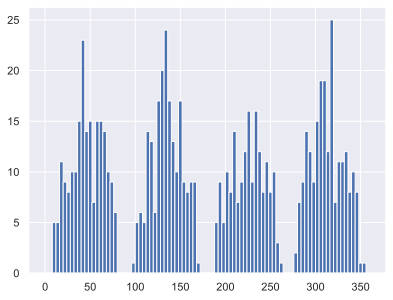

In [42]:
plt.hist(dfN.movAngle,bins=90, range=(0,360));

### Statistics of angle and speed error
TBD: 
- Normality test
- skewness and kurtosis
- significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [43]:
errAngle = dfN.tapAngle - dfN.movAngle
print(np.mean(errAngle))
print(np.std(errAngle))

0.16464207238111606
12.573791197290275


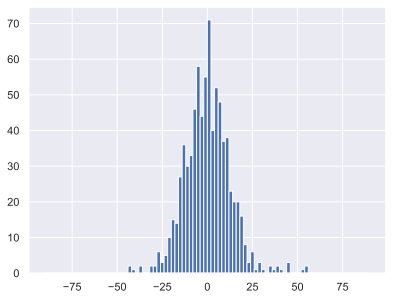

In [44]:
plt.hist(errAngle, bins=90, range=(-90,90));

13.033248729090545
26.16883952364156


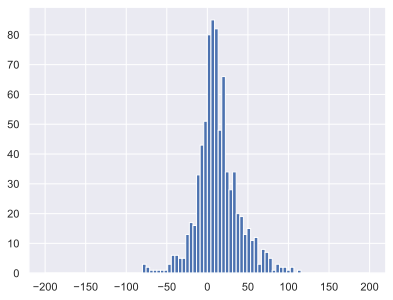

In [45]:
errSpeed = dfN.movSpeed - dfN.tapSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
plt.hist(errSpeed, bins=90, range=(-200,200));

Do participant think longer when they have smaller errors? Apparently not.

Text(0.5, 1.0, 'start tapping time as a function of angle error')

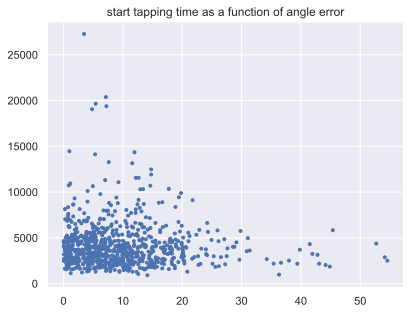

In [46]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN[['tapHor','tapVer']].min(axis=1) - dfN.movStart ), '.')
ax.set_title('start tapping time as a function of angle error')

### TBD
- regression of speed error vs stimulus angle (deviation from diagonal)
- regression of angle error vs stimulus angle (deviation from diagonal)

### TBD
Comparison of speed and angle error between Task A and Task B

### TBD
Analysis of relative speed error (percent error)

### TBD

Analysis of questionnaires, as in [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411)